In [1]:
from data_helper import get_dataloaders_and_standarscaler_photons, get_dataloaders_and_standarscaler_photons_from_numpy
from train_helper import train_vae, train_vae_mmd
from plot_helper import plot_training_loss
from models_architecture_helper import VAE_Linear_0703

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
#TODO czy zapisywać Logging interval ? 
#TODO i czy zapisywać całkowity number of epochs gdyby we wczytanym modelu robić kolejnego checkpointa

In [3]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 10000
NUM_EPOCHS = 30
LOGGING_INTERVAL=300
RECONSTRUCTION_TERM_WEIGHT=1

PLOT_FRACTION=0.0125
TEST_FRACTION=0.4
VALIDATION_FRACTION=0.0
SAVE_MODEL_FILE='checkpoint.pth'
NUM_WORKERS=0
path='/data1/dose-3d-generative/data/training-data/DISP_0.5_ANGLE_0/NUMPY/a1_10_7.npy'

In [4]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [5]:
print(torch.cuda.memory_allocated(device=DEVICE))
print(torch.cuda.memory_reserved(device=DEVICE))
print(torch.cuda.get_device_name(0))

0
0
Quadro RTX 8000


In [6]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros((10000001, 6),dtype=np.float32)
np.copyto(X,photons[:,:-1])
print(X.shape)

(10000001, 6)


In [7]:
X_reflection=copy.deepcopy(X)
X_reflection[:,2]=-X_reflection[:,2]
X_reflection[:,4]=-X_reflection[:,4]

X_sum=np.concatenate((X,X_reflection),axis=0)
print(len(X_sum))

20000002


In [8]:
df_data = pd.DataFrame(X_sum, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.77526,-0.50856,-4.60704,-0.018979,-0.177872,0.983871
1,0.77526,-0.77813,-5.10840,-0.029292,-0.196501,0.980066
2,0.45010,-3.74409,-1.33591,-0.145330,-0.051869,0.988023
3,0.39630,-2.50916,-3.30103,-0.274393,-0.273584,0.921879
4,0.45010,-4.79711,-1.70242,-0.184824,-0.065606,0.980579


In [9]:
tmp_check=df_data.to_numpy(dtype=np.float32)
orginal_check=copy.deepcopy(tmp_check)

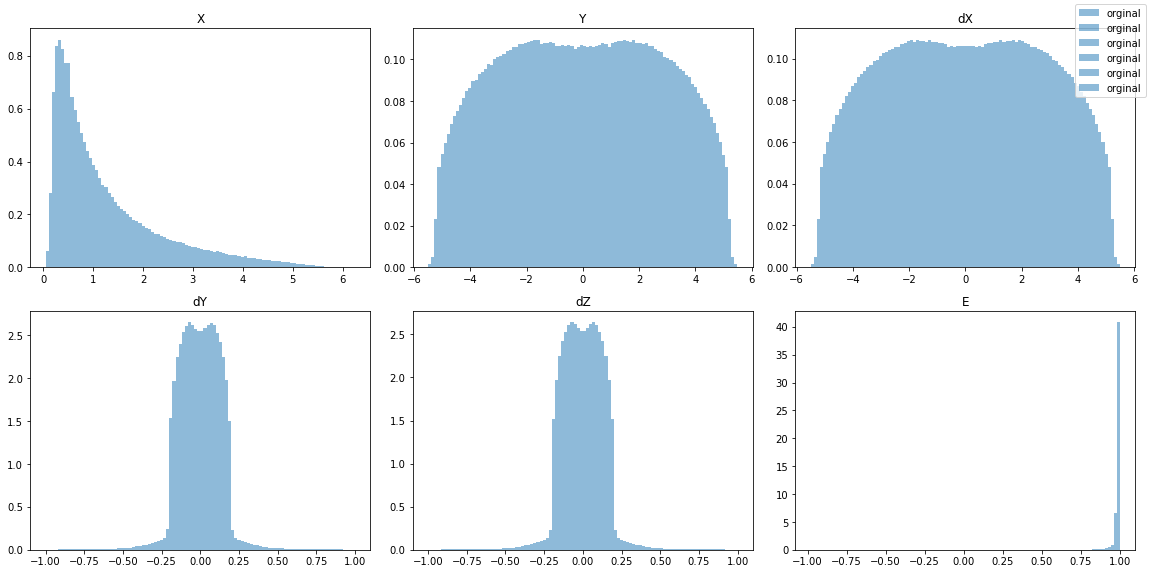

In [10]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal_check[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal_check[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal_check[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal_check[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal_check[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal_check[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

fig.tight_layout()

In [11]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons_from_numpy(tmp_X=X_sum,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    test_fraction=TEST_FRACTION, 
    validation_fraction=VALIDATION_FRACTION)

In [12]:
model = VAE_Linear_0703()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, 
                             weight_decay=1e-5)

In [13]:
log_dict=train_vae_mmd(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE)

Epoch: 001/030 | Batch 0000/1200 | Loss: 8.4597
Epoch: 001/030 | Batch 0300/1200 | Loss: 6.6622
Epoch: 001/030 | Batch 0600/1200 | Loss: 4.1009
Epoch: 001/030 | Batch 0900/1200 | Loss: 2.5856
***Epoch: 001/030 | Loss: 2.233
Test***Epoch: 001/030 | Loss: 2.238
Time elapsed: 20.14 min
Epoch: 002/030 | Batch 0000/1200 | Loss: 2.4919
Epoch: 002/030 | Batch 0300/1200 | Loss: 1.5132
Epoch: 002/030 | Batch 0600/1200 | Loss: 0.9048
Epoch: 002/030 | Batch 0900/1200 | Loss: 0.8043
***Epoch: 002/030 | Loss: 0.629
Test***Epoch: 002/030 | Loss: 0.629
Time elapsed: 40.44 min
Epoch: 003/030 | Batch 0000/1200 | Loss: 0.5633
Epoch: 003/030 | Batch 0300/1200 | Loss: 0.5284
Epoch: 003/030 | Batch 0600/1200 | Loss: 0.4937
Epoch: 003/030 | Batch 0900/1200 | Loss: 0.4436
***Epoch: 003/030 | Loss: 0.371
Test***Epoch: 003/030 | Loss: 0.372
Time elapsed: 60.78 min
Epoch: 004/030 | Batch 0000/1200 | Loss: 0.3830
Epoch: 004/030 | Batch 0300/1200 | Loss: 0.3720
Epoch: 004/030 | Batch 0600/1200 | Loss: 0.3722
Epoc

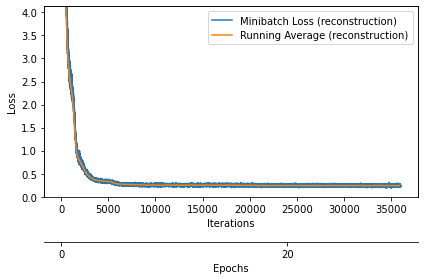

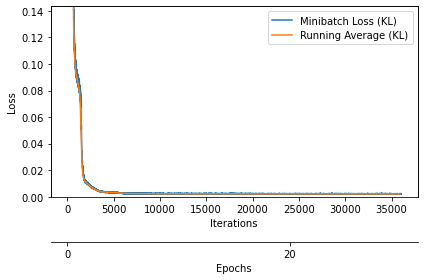

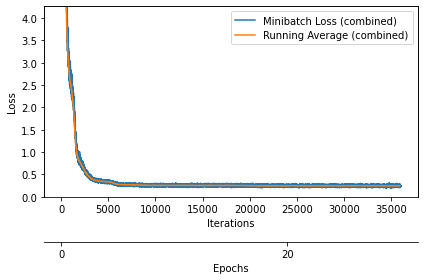

In [14]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



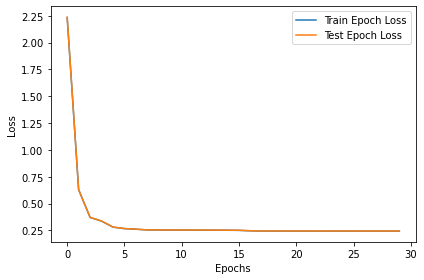

In [15]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [16]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

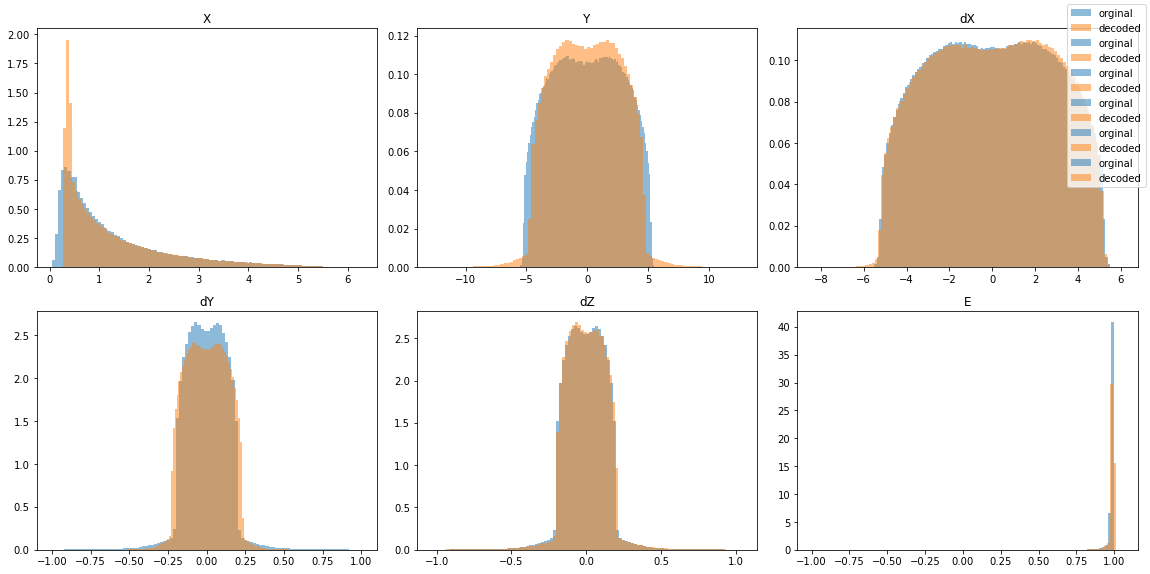

In [17]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

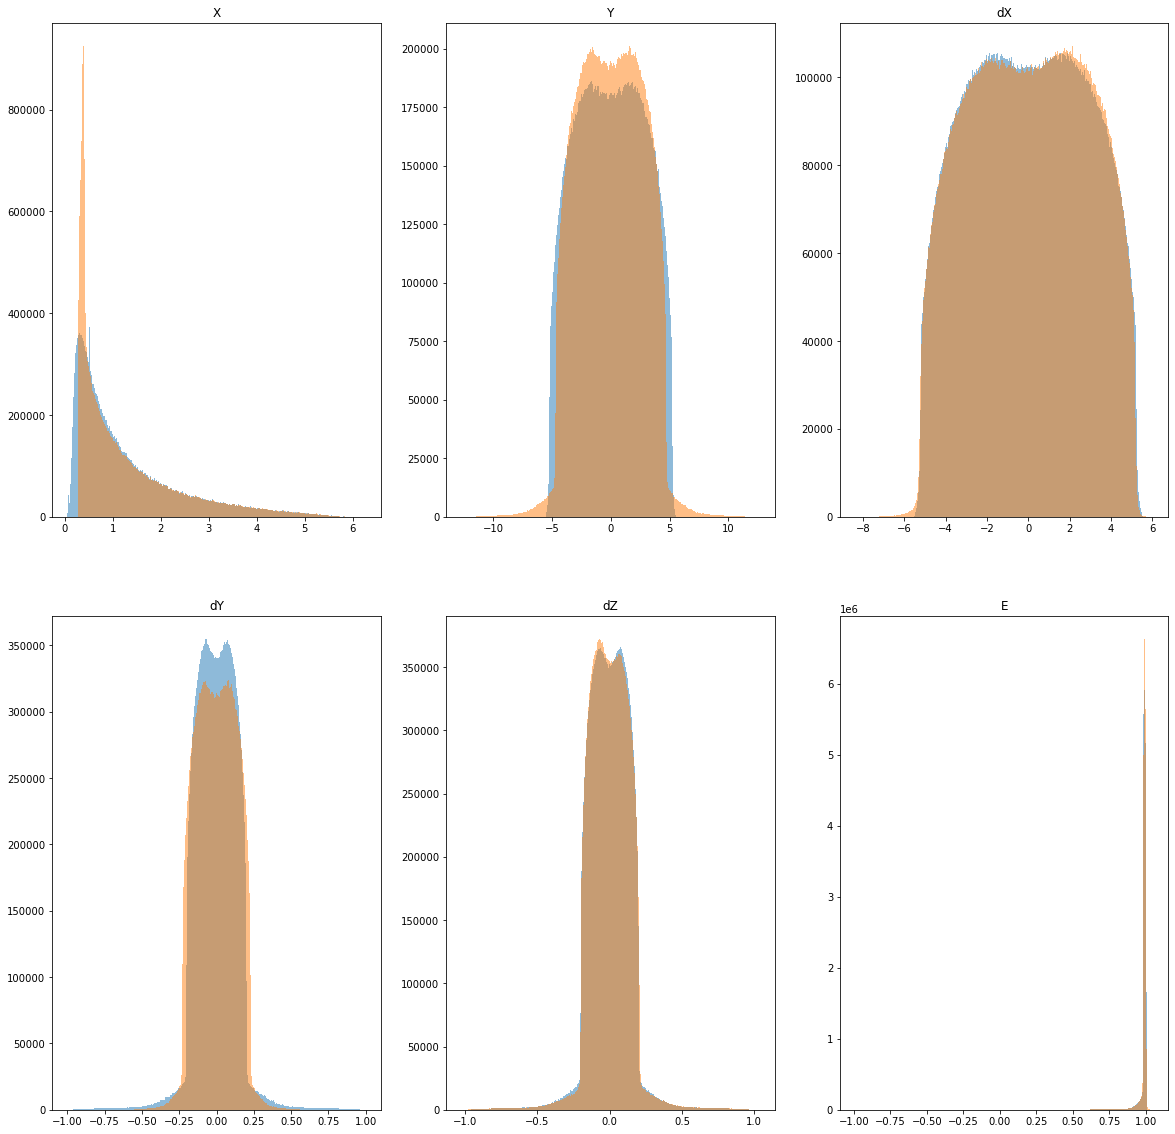

In [18]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)

In [19]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [20]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample_concatenated=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_concatenated.shape)
print(sample_concatenated.head())

(500000, 7)
                 X         Y        dX        dY        dZ         E  \
31583840  0.722596  1.763072  1.079117  0.085096  0.037795  0.995045   
34539943  0.283723  2.209071  4.984990  0.106127  0.185747  0.976564   
20004843  0.393364  3.558454 -3.808462  0.173544 -0.147108  0.977102   
20169494  1.223245  0.540280  0.034502  0.032151  0.271877  0.925668   
38060417  0.343315 -5.007077  2.104751 -0.241468  0.217327  0.927776   

         dataset_name  
31583840      decoded  
34539943      decoded  
20004843      decoded  
20169494      decoded  
38060417      decoded  


In [21]:
sample_orginal=orginal_df.apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_orginal.shape)
print(sample_orginal.head())

(250000, 6)
                X        Y       dX        dY        dZ         E
11583838  0.72217  1.91911  1.02320  0.075932  0.040737  0.996280
14539941  0.19622  2.45577  4.91175  0.094408  0.188461  0.977532
4841      0.36820  3.95641 -3.81723  0.152133 -0.146734  0.977407
169492    1.24696  4.82186 -0.47056 -0.187327  0.301854  0.934769
18060415  0.46350 -3.66491  2.14019 -0.309671  0.214503  0.926333


In [22]:
# sns.pairplot(sample_orginal, kind="scatter")

In [23]:
sample_decoded=decoded_df.apply(lambda x: x.sample(frac=PLOT_FRACTION, random_state=2)) 
print(sample_decoded.shape)
print(sample_decoded.head())

(250000, 6)
                 X         Y        dX        dY        dZ         E
11583838  0.722596  1.763072  1.079117  0.085096  0.037795  0.995045
14539941  0.283723  2.209071  4.984990  0.106127  0.185747  0.976564
4841      0.393364  3.558454 -3.808462  0.173544 -0.147108  0.977102
169492    1.223245  0.540280  0.034502  0.032151  0.271877  0.925668
18060415  0.343315 -5.007077  2.104751 -0.241468  0.217327  0.927776


In [24]:
# sns.pairplot(sample_decoded, kind="scatter")

In [25]:
# sns.pairplot(sample_concatenated, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

# g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# #g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

# sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)

In [26]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [27]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [28]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.359750,2.614970,-4.698670,0.100502,-0.180584,0.978411
1,2.363958,2.346524,-4.732101,0.115049,-0.178816,0.979417


In [29]:
# encoded_features=[]
# model.eval()
# for index, feature in enumerate(train_loader):
#     with torch.no_grad():
#         tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
#         encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
# encoded_features=np.asarray(encoded_features)

# print(encoded_features.shape)

In [30]:
# #PRZESTRZEŃ UKRYTA VAE
# colors = ['r']
# markers = ['s']

# fig=plt.figure()
# ax=fig.add_subplot(projection='3d')
# for c, m in zip(colors, markers):
#     ax.scatter(encoded_features[:,0],encoded_features[:,2],encoded_features[:,1],marker=m,c=c)

# ax.set_xlabel('VAE 1')
# ax.set_ylabel('VAE 2')
# ax.set_zlabel('VAE 3')

# plt.show()